# Fitting a quadriatic form
Here lets consider the problem of optimizing elements of a coefficient matrix $A$ that generates a polynomial through a quadriatic form:
$$Q(x) \equiv y^T A y = ax^2 + 2bx + c$$
where 
$$ A \equiv \begin{bmatrix}
a & b/2 \\
b/2 & c \\
\end{bmatrix}
\quad 
y \equiv \begin{bmatrix} x & 1 \end{bmatrix}^T
$$

In [378]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

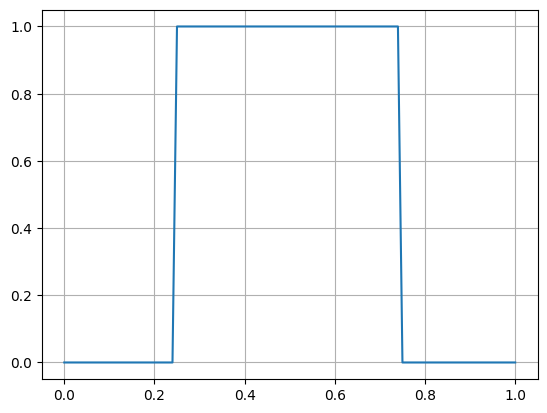

In [485]:
# parameters_ideal = torch.tensor([1,1,0.5],dtype=torch.float64)
# plt.plot(w,np.abs(computeValues(parameters_ideal,w))); plt.grid()

polynomial_target = torch.zeros(len(w))
polynomial_target = torch.zeros(len(w))
polynomial_target[int(0.25*len(w)):int(0.75*len(w))] = 1
plt.plot(w,abs(polynomial_target)); plt.grid()


In [486]:
w = torch.linspace(0,1,101,dtype=torch.complex128) # for plotting
# parameters_ideal = torch.tensor([1,1,0.5],dtype=torch.float64)
parameters = torch.tensor([1,0.2,4],dtype=torch.float64,requires_grad=True)

def computeValues(parameters, w):
    L1,C1,G1 = parameters

    # Efficiently compute components of the matrix
    top_left = 1 - L1 * C1 * (w**2)       # 1 + a * (x^2)
    top_right = 1j*L1 * w               # b * x
    bottom_left = G1+1j*C1 * w             # c * x
    bottom_right = torch.ones_like(w)  # Constant 1

    # Q = top_left/bottom_left
    
    # Stack the components into a 3D tensor
    matrix_tensor = torch.stack([
        torch.stack([top_left, top_right], dim=-1),    # Row 1 of each matrix
        torch.stack([bottom_left, bottom_right], dim=-1)  # Row 2 of each matrix
    ], dim=-2)  # Combine rows into a matrix
    
    # matrix_tensor_final = matrix_tensor
    # matrix_tensor_final = matrix_tensor @ matrix_tensor # leading indices are batch, rmbr, so that matmul hapeens between the last two indices, which is crrect here
    # matrix_tensor_final = matrix_tensor @ matrix_tensor @ matrix_tensor
    # matrix_tensor_final = matrix_tensor @ matrix_tensor @ matrix_tensor @ matrix_tensor
    matrix_tensor_final = matrix_tensor @ matrix_tensor @ matrix_tensor @ matrix_tensor @ matrix_tensor
    Q = matrix_tensor_final[:,0,0]/matrix_tensor_final[:,1,0]
    return Q

def computeError(parameters):
    polynomial_w = computeValues(parameters,w)
    # polynomial_target = computeValues(parameters_ideal,w)
    # loss = torch.nn.MSELoss()(polynomial_w,polynomial_target)
    loss = torch.sum(
        torch.abs(polynomial_w-polynomial_target)**2
    )
    return loss

Iteration 600 : tensor([0.5923, 1.5916, 0.6762], dtype=torch.float64, requires_grad=True);  f = 28.126281336696277
Iteration 700 : tensor([0.5923, 1.5916, 0.6762], dtype=torch.float64, requires_grad=True);  f = 28.1262813365705
Iteration 800 : tensor([0.5923, 1.5916, 0.6762], dtype=torch.float64, requires_grad=True);  f = 28.126281336903606
Iteration 900 : tensor([0.5924, 1.5918, 0.6762], dtype=torch.float64, requires_grad=True);  f = 28.126377274150087


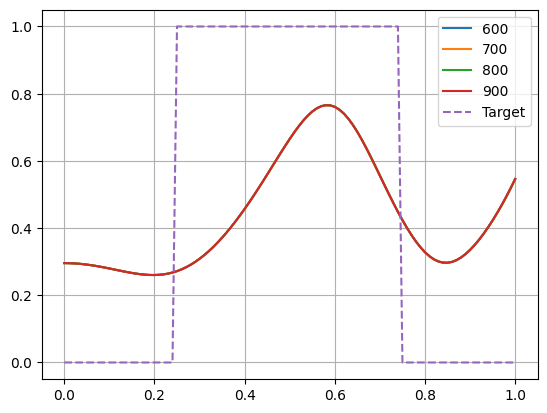

In [487]:
fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([parameters], lr=0.1) # Adaptive algorithm, better
for i in range(1000):
    optimizer.zero_grad()
    f = computeError(parameters)
    # f = torch.nn.MSELoss()(parameters_ideal,parameters)
    f.backward()
    optimizer.step()
    if(i%100==0 and i> 500):
        print(f'Iteration {i} : {parameters};  f = {f.item()}')
        axes.plot(w,abs(computeValues(parameters,w)).detach().numpy())
        legend.append(i)
legend.append('Target')
# axes.plot(w,abs(computeValues(parameters_ideal,w)).detach().numpy(),linestyle='dashed')
# print(f'Ideal parameters: {parameters_ideal}')
axes.plot(w,abs(polynomial_target).detach().numpy(),linestyle='dashed')
axes.legend(legend)
axes.grid('on')